# <center> CLAP Analysis </center>

#### <center> Analyzing our generated music with the CLAP model

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [13]:
from datasets import Dataset, Audio
import librosa
import torchaudio
import torch.nn.functional as F
import torch
from matplotlib import pyplot as plt
import numpy as np

from transformers import ClapModel, ClapProcessor

class CLAPAnalysis:
    def __init__(self, model_checkpoint="laion/clap-htsat-unfused"):
        self.model_checkpoint = model_checkpoint
        self.model = ClapModel.from_pretrained(model_checkpoint)
        self.processor = ClapProcessor.from_pretrained(model_checkpoint)
        self.sample_rate = self.processor.feature_extractor.sampling_rate

    def resample(self, waveform, sample_rate):
        """Resample the audio waveform so that it matches the model's sample rate.
        
        Args:
            waveform (array): The audio waveform to resample.
            sample_rate (int): The sample rate of the waveform.

        Returns:
            (array): The resampled waveform.
        """
        if sample_rate != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, self.sample_rate)
        return waveform

    def split(self, sample_array, batch_duration=5):
        """Split the audio into batches of the desired duration to track the embeddings over time.
        
        Args:
            sample_array (array): The audio waveform to split.
            batch_duration (int): The duration of each batch in seconds.

        Returns:
            (list(array)): A list of arrays, each representing a batch of the audio.
        """
        waveform = sample_array.squeeze().numpy()
        batch_size = int(batch_duration * self.sample_rate)
        return [waveform[i:i+batch_size] for i in range(0, len(waveform), batch_size)]

    def preprocess_audio(self, audio):
        """Do audio proprocessing, inclusing resampling and splitting into batches.
        
        Args:
            audio (str, tuple, dict): The audio to process. Can be a file path, a tuple of waveform and sample rate,
                or a dictionary with 'array' and 'rate' keys.
            batch_duration (int): The duration of each batch in seconds.
        
        Returns:
            (list(array)): A list of arrays, each representing a batch of the audio.
        """
        if isinstance(audio, str):
            sample_array, sample_rate = torchaudio.load(audio)
        elif isinstance(audio, tuple):
            sample_array, sample_rate = audio
        elif isinstance(audio, dict):
            sample_array, sample_rate = audio['array'], audio['sampling_rate']
            sample_array = torch.tensor(sample_array)
        else:
            raise ValueError("Audio input is not recognized. Must be a file path, a tuple of waveform "
                             "and sample rate, or a dictionary with 'array' and 'rate' keys.")
        if sample_array.ndim == 2:
            sample_array = torch.mean(sample_array, dim=0, keepdim=True)    # Convert stereo to mono
        return self.resample(sample_array, sample_rate).squeeze()

    def batch_audio(self, audio_file, batch_duration=5):
        """Batch the audio into smaller sections to track the embeddings over time.
        
        Args:
            audio_file (str): The audio file to process.
            batch_duration (int): The duration of each batch in seconds.
        
        Returns:
            (list(array)): A list of arrays, each representing a batch of the audio.
        """
        waveform = self.preprocess_audio(audio_file)
        return self.split(waveform, batch_duration=batch_duration)

    def embed_audio(self, samples):
        """Embeds the audio into the CLAP feature space.

        Args:
            audio (str, tuple, dict): The audio to process. Can be a file path, a tuple of waveform and sample rate,
                or a dictionary with 'array' and 'rate' keys.
            batch_duration (int): The duration of each batch in seconds.

        Returns:
            (array): The audio embeddings.
        """
        inputs = self.processor(audios=samples, return_tensors="pt", sampling_rate=self.sample_rate)
        with torch.no_grad():
            outputs = self.model.get_audio_features(**inputs)
        return outputs

    def embed_text(self, text):
        """Embeds the text into the CLAP feature space.

        Args:
            text (list(str)): A list of texts to process.

        Returns:
            (array): The text embeddings.
        """
        inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model.get_text_features(**inputs)
        return outputs

    def analyze(self, audio, classes, batch_duration=5):
        """Analyzes the audio and text classes to determine the similarity between the two.

        Args:
            audio (str, tuple, dict): The audio to process. Can be a file path, a tuple of waveform and sample rate,
                or a dictionary with 'array' and 'rate' keys.
            classes (list(str)): A list of texts to compare to the audio batches.
            batch_duration (int): The duration of each batch in seconds.

        Returns:
            (array): The similarity scores between each batch of audio and the text classes.
        """
        waveform = self.preprocess_audio(audio)
        if batch_duration == 0:
            samples = [waveform.numpy()]
        else: 
            samples = self.split(waveform, batch_duration=batch_duration)
        audio_embeddings = F.normalize(self.embed_audio(samples), p=2, dim=1)
        text_embeddings = F.normalize(self.embed_text(classes), p=2, dim=1)
        return torch.matmul(audio_embeddings, text_embeddings.T)

    def compare_text(self, audio, text, batch_duration=5):
        """Compares the audio to the given text.

        Args:
            audio (str, tuple, dict): The audio to process. Can be a file path, a tuple of waveform and sample rate,
                or a dictionary with 'array' and 'rate' keys.
            text (str): The text to compare to the audio.

        Returns:
            (array): The similarity scores between each batch of audio and the text.
        """
        audio_embeddings = analysis_model.embed_audio(audio_file)
        num_sections = audio_embeddings.shape[0]
        part_length = len(text) // num_sections
        text_parts = [text[i:i+part_length] for i in range(0, len(text), part_length)][:num_sections]
        text_embeddings = analysis_model.embed_text(text_parts)
        return (audio_embeddings * text_embeddings).sum(dim=1)

    def compare_audio(self, audio, batch_duration=5):
        """Compares audio sections to each other. Get the cosine similarity of adjacent audio sections to see whether
        the audio remains similar over time.
        """
        waveform = self.preprocess_audio(audio)
        if batch_duration == 0:
            samples = [waveform.numpy()]
        else:
            samples = self.split(waveform, batch_duration=batch_duration)
        audio_embeddings = analysis_model.embed_audio(samples)
        return (audio_embeddings[:-1] * audio_embeddings[1:]).sum(dim=1)
        

### Define Model and Files

In [14]:
model_checkpoint = "laion/clap-htsat-unfused"
analysis_model = CLAPAnalysis(model_checkpoint=model_checkpoint)

In [15]:
analysis_model.sample_rate

48000

## Sentiment Analysis

In [16]:
audio_file = "uploads/balrog audio_5_backing.mp3"

In [17]:
def plot_scores_over_time(scores, classes, batch_duration, colors=None):
    # Initialize parameters
    colors = colors or ["C3", "y", "C2", "C1", "C0", "C4"]  # Default colors
    num_sections = scores.shape[0]
    seconds = np.arange(1, num_sections+1)*batch_duration

    # Plot the scores over time
    for i, emotion in enumerate(classes):
        plt.plot(seconds, scores[:, i].numpy(), c=colors[i], label=emotion)
    plt.xlabel("Seconds")
    plt.ylabel("Score")
    plt.title("Song Emotion Progression")   
    plt.legend(loc="lower left")
    plt.show()

In [18]:
batch_duration = 10

In [19]:
classes = ["love", "joy", "surprise", "anger", "sadness", "fear"]
scores = analysis_model.analyze(audio_file, classes, batch_duration=batch_duration)
scores

tensor([[ 0.3273,  0.1624, -0.0381,  0.1713,  0.4210,  0.3728],
        [ 0.3687,  0.1698, -0.0561,  0.0846,  0.4337,  0.2962],
        [ 0.2781,  0.1770, -0.0228,  0.0849,  0.3577,  0.3325],
        [ 0.3530,  0.2205,  0.0103,  0.2055,  0.4632,  0.4140],
        [ 0.3078,  0.1581, -0.0495,  0.1806,  0.4483,  0.3744],
        [ 0.3212,  0.2349,  0.0258,  0.1762,  0.3660,  0.3726],
        [ 0.3585,  0.2648,  0.0396,  0.1130,  0.3180,  0.2878],
        [ 0.3365,  0.2466,  0.0423,  0.1372,  0.4198,  0.3047],
        [ 0.3762,  0.2462,  0.0057,  0.0730,  0.3708,  0.2804]])

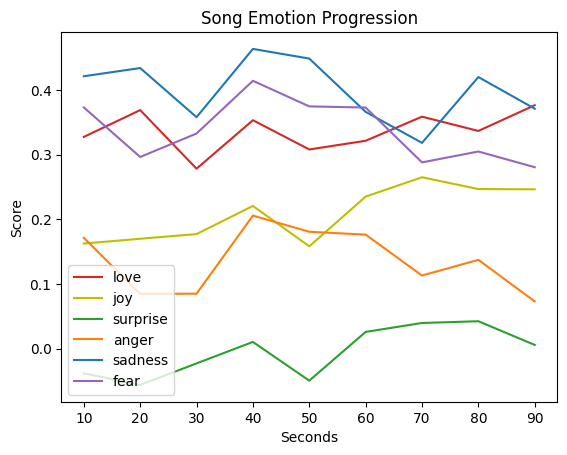

In [20]:
plot_scores_over_time(scores, classes, batch_duration=batch_duration)

In [21]:
song_classes = [f"{emotion} song" for emotion in classes]
song_scores = analysis_model.analyze(audio_file, song_classes, batch_duration=batch_duration)
song_scores

tensor([[0.3496, 0.0731, 0.3341, 0.2249, 0.4640, 0.5535],
        [0.3462, 0.0611, 0.2561, 0.1757, 0.4242, 0.4510],
        [0.2898, 0.0714, 0.2935, 0.1823, 0.4000, 0.4702],
        [0.3718, 0.1213, 0.3380, 0.2626, 0.5131, 0.5884],
        [0.3364, 0.0859, 0.2939, 0.2381, 0.4750, 0.5228],
        [0.3694, 0.1565, 0.3346, 0.2937, 0.4556, 0.5439],
        [0.3699, 0.1809, 0.3117, 0.2841, 0.4254, 0.4983],
        [0.3353, 0.1057, 0.3378, 0.2263, 0.4514, 0.5057],
        [0.3830, 0.0928, 0.2776, 0.1915, 0.3861, 0.4466]])

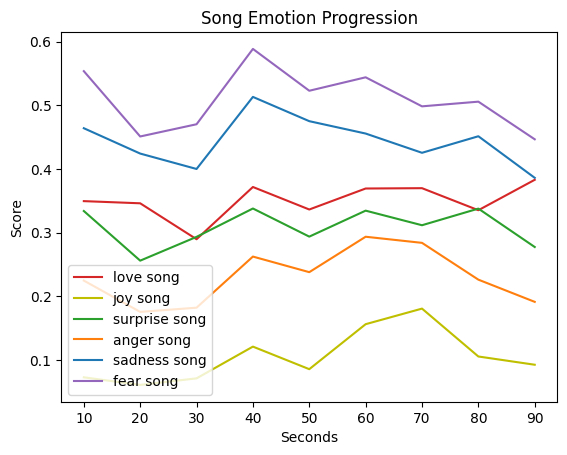

In [22]:
plot_scores_over_time(song_scores, song_classes, batch_duration=batch_duration)

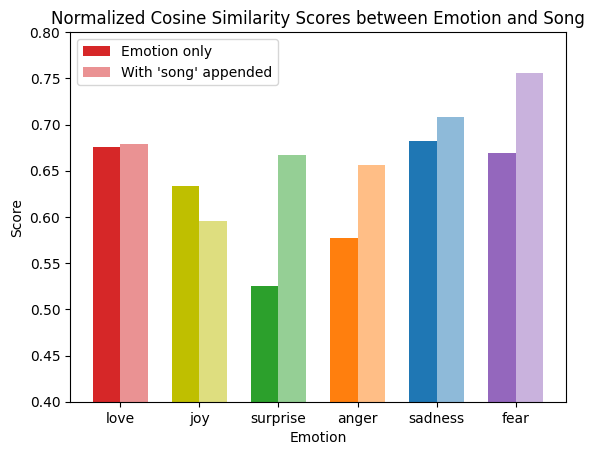

In [20]:
vals = analysis_model.analyze(audio_file, classes, batch_duration=0)
song_vals = analysis_model.analyze(audio_file, song_classes, batch_duration=0)
x = np.arange(len(classes))
width = 0.35
colors = ["C3", "y", "C2", "C1", "C0", "C4"]

plt.bar(x-width/2, (vals.squeeze().numpy()+1)/2, width=width, color=colors, label="Emotion only")
plt.bar(x+width/2, (song_vals.squeeze().numpy()+1)/2, width=width, color=colors, alpha=0.5, label="With 'song' appended")

plt.xlabel("Emotion")
plt.ylabel("Score")
plt.xticks(x, classes)
# plt.yscale('log')
plt.ylim(.4, .8)
plt.legend()
plt.title("Normalized Cosine Similarity Scores between Emotion and Song")
plt.show()

## Textual Similarity

In [5]:
filenames = ['rots', 'fotr_balrog', 'raj', 'cith', 'wok_war']

In [6]:
import os

# Load text excerpts
text_dir = "evaluation/excerpts/"
texts = []
for filename in filenames:
    with open(f"{text_dir}{filename}.txt") as f:
        text = f.read()
        texts.append(' '.join(text.split()[:300]))   # Limit to 60 words

In [7]:
# Load generated audio
audio_dir = "evaluation/generated_songs/"
songs = []
for filename in filenames:
    songs.append(f"{audio_dir}{filename}.wav")

In [8]:
audio_dir = "evaluation/generated_songs/"
songs = [analysis_model.preprocess_audio(f"{audio_dir}{filename}.wav").numpy() for filename in filenames]

In [9]:
inputs = analysis_model.processor(text=texts, audios=songs, return_tensors="pt", padding=True, sampling_rate=48000)
with torch.no_grad():
    outputs = analysis_model.model(**inputs)

probs = outputs.logits_per_audio.softmax(dim=-1)
probs

tensor([[0.5345, 0.2478, 0.1100, 0.0167, 0.0910],
        [0.0965, 0.2106, 0.0013, 0.0012, 0.6905],
        [0.1908, 0.2726, 0.2522, 0.0032, 0.2812],
        [0.2991, 0.1652, 0.4587, 0.0418, 0.0353],
        [0.2836, 0.5544, 0.0670, 0.0050, 0.0901]])

Text(0.5, 1.0, 'Cosine Similarity Between Text Excerpts and Generated Songs')

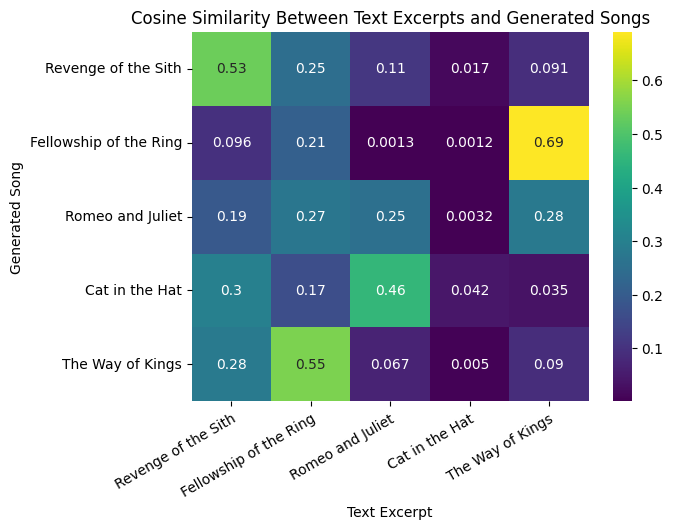

In [11]:
import seaborn as sns

books = ["Revenge of the Sith", "Fellowship of the Ring", "Romeo and Juliet", "Cat in the Hat", "The Way of Kings"]
sns.heatmap(probs.numpy(), annot=True, xticklabels=books, yticklabels=books, cmap='viridis')
plt.xlabel("Text Excerpt")
plt.ylabel("Generated Song")
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
plt.title("Cosine Similarity Between Text Excerpts and Generated Songs")

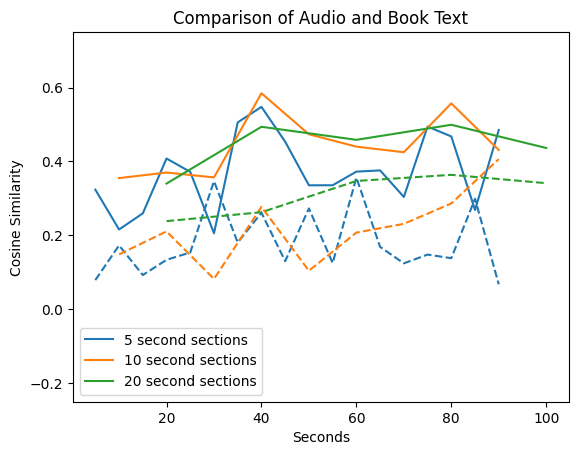

In [14]:
# Old plots


inputs = processor(text=text, audios=convert_audio, return_tensors="pt", padding=True, sampling_rate=48000) # , max_length=1024
outputs = model(**inputs)
print(outputs.keys())
text_embeds, audio_embeds = outputs.text_embeds, outputs.audio_embeds

logit_res = outputs.logits_per_audio.softmax(dim=-1)
logit_res = logit_res.detach().numpy()
print(logit_res)


plt.figure(figsize=(8, 6))  # Optional: Specifies the figure size
sns.heatmap(logit_res, annot=True, cmap='viridis')  # 'annot' annotates the boxes with matrix_data numbers
plt.show()

## Audio Consistency

In [4]:
audio_file = "uploads/balrog audio_5_backing.mp3"
batch_durations = [5, 10, 20]
num_random_samples = 10

In [5]:
from datasets import load_dataset

dataset = load_dataset("ashraq/esc50")["train"]["audio"]

/home/cayjobla/PAGES/.venv/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [6]:
random_audios = [analysis_model.preprocess_audio(audio).numpy() for audio in np.random.choice(dataset, num_random_samples)]
random_embeds = analysis_model.embed_audio(random_audios)

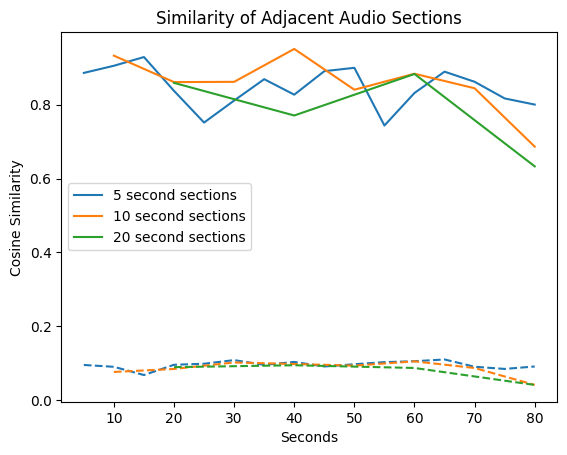

In [11]:
for i, batch_duration in enumerate(batch_durations):
    audio_batch = analysis_model.batch_audio(audio_file, batch_duration)
    if batch_duration == 5:
        audio_batch = audio_batch[:-1]
    audio_embed = analysis_model.embed_audio(audio_batch)
    audio_similarity = (audio_embed[:-1] * audio_embed[1:]).sum(dim=1)
    baseline_similarity = torch.matmul(random_embeds, audio_embed.T).mean(dim=0)[1:]

    seconds = np.arange(1,len(audio_batch))*batch_duration
    plt.plot(seconds, audio_similarity, label=f"{batch_duration} second sections", c=f"C{i}")
    plt.plot(seconds, baseline_similarity, linestyle="--", c=f"C{i}")

# plt.ylim(-0.1, 1.)
plt.title("Similarity of Adjacent Audio Sections")
plt.ylabel("Cosine Similarity")
plt.xlabel("Seconds")
plt.legend(loc="center left")
plt.show()

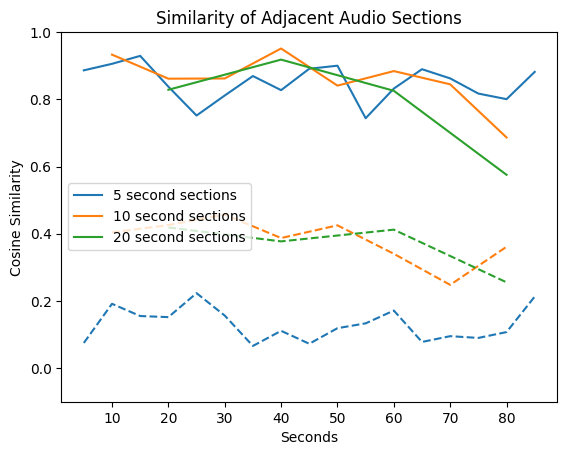

In [ ]:
plt.plot(np.arange(1,len(audio_similarity_5)+1)*5, audio_similarity_5, label="5 second sections")
plt.plot(np.arange(1,len(audio_similarity_10)+1)*10, audio_similarity_10, label="10 second sections")
plt.plot(np.arange(1,len(audio_similarity_20)+1)*20, audio_similarity_20, label="20 second sections")
plt.plot(np.arange(1,len(audio_dissimilarity_5)+1)*5, audio_dissimilarity_5, linestyle="--", color="C0")
plt.plot(np.arange(1,len(audio_dissimilarity_10)+1)*10, audio_dissimilarity_10, linestyle="--", color="C1")
plt.plot(np.arange(1,len(audio_dissimilarity_20)+1)*20, audio_dissimilarity_20, linestyle="--", color="C2")
plt.ylim(-0.1, 1.)
plt.title("Similarity of Adjacent Audio Sections")
plt.ylabel("Cosine Similarity")
plt.xlabel("Seconds")
plt.legend(loc="center left")
plt.show()

The drop at the end may be a result of me padding the audio sections with silence to be the same length